## 1.Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

/home/mr-rider/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [4]:
# Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# Напишем функцию, реализующую предсказание в градиентном бустинге.
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [6]:
# В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [7]:
# Используем 𝐿2 loss 𝐿(𝑦,𝑧)=(𝑦−𝑧)2, ее производная по 𝑧 примет вид 𝐿′(𝑦,𝑧)=2(𝑧−𝑦). Реализуем ее также в виде функции.
def bias(z, y):
    return 2 * (z - y)

In [8]:
# Реализуем функцию обучения градиентного бустинга.
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    
    err_train_mse = round(mean_squared_error(y_train, train_prediction))
    #print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    #с шагом {eta} на тренировочной выборке: {err_train_mse}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    
    err_test_mse = round(mean_squared_error(y_test, test_prediction))
    #print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    #с шагом {eta} на тестовой выборке: {err_test_mse}')
    return err_train_mse, err_test_mse

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

(1095, 4845)

In [12]:
# Зависимость mse от количества деревьев
n_trees_list =[]
err_train_list = []
err_test_list = []
max_depth = 5
# Шаг
eta = 0.5
for n_trees in range(3, 50, 5):
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    err_train, err_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    print(f'Number of trees: {n_trees}, error train: {err_train}, err_test: {err_test} ')
    err_train_list.append(err_train)
    err_test_list.append(err_test)
    n_trees_list.append(n_trees)
    
    


    

Number of trees: 3, error train: 1077, err_test: 3698 
Number of trees: 8, error train: 290, err_test: 5557 
Number of trees: 13, error train: 80, err_test: 6128 
Number of trees: 18, error train: 17, err_test: 5952 
Number of trees: 23, error train: 4, err_test: 5919 
Number of trees: 28, error train: 1, err_test: 5974 
Number of trees: 33, error train: 0, err_test: 5956 
Number of trees: 38, error train: 0, err_test: 5957 
Number of trees: 43, error train: 0, err_test: 5956 
Number of trees: 48, error train: 0, err_test: 5955 


In [13]:
import matplotlib.pyplot as plt

In [18]:
def get_error_plot(n_trees_list, err_train_list, err_test_list):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE error')
    plt.xlim(0, 50)
    #plt.ylim(0, )
    plt.plot(n_trees_list, err_train_list, label='train error')
    plt.plot(n_trees_list, err_test_list, label='test error')
    plt.legend(loc='upper right')
    plt.show()

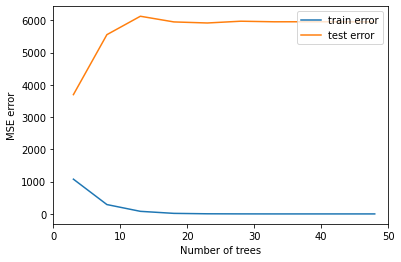

In [19]:
get_error_plot(n_trees_list, err_train_list, err_test_list)

### Вывод: при увеличении количества деревьев ошибка на трейне падает и стабилизируется при достижении 15 деревьев.  А на тесте ошибка растет и стабилизируется при 15 деревьях. Возникает переобучение модели.

In [26]:
# Зависимость MSE от глубины деревьев
n_trees = 3
err_train_list = []
err_test_list = []
max_depth_list = []
# Шаг
eta = 0.5
for max_depth in range(1, 20 ):
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    err_train, err_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    print(f'Max_depth: {max_depth}, error train: {err_train}, err_test: {err_test} ')
    err_train_list.append(err_train)
    err_test_list.append(err_test)
    max_depth_list.append(max_depth)

Max_depth: 1, error train: 3312, err_test: 3002 
Max_depth: 2, error train: 2815, err_test: 3324 
Max_depth: 3, error train: 2089, err_test: 3563 
Max_depth: 4, error train: 1559, err_test: 4126 
Max_depth: 5, error train: 1077, err_test: 3698 
Max_depth: 6, error train: 468, err_test: 4701 
Max_depth: 7, error train: 388, err_test: 4448 
Max_depth: 8, error train: 61, err_test: 6046 
Max_depth: 9, error train: 37, err_test: 4818 
Max_depth: 10, error train: 3, err_test: 4182 
Max_depth: 11, error train: 2, err_test: 5479 
Max_depth: 12, error train: 0, err_test: 5564 
Max_depth: 13, error train: 0, err_test: 5247 
Max_depth: 14, error train: 0, err_test: 5506 
Max_depth: 15, error train: 0, err_test: 5272 
Max_depth: 16, error train: 0, err_test: 5734 
Max_depth: 17, error train: 0, err_test: 5950 
Max_depth: 18, error train: 0, err_test: 5950 
Max_depth: 19, error train: 0, err_test: 5950 


In [29]:
def get_error_plot(max_depth_list, err_train_list, err_test_list):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE error')
    #plt.xlim(0, 20)
    #plt.ylim(0, )
    plt.plot(max_depth_list, err_train_list, label='train error')
    plt.plot(max_depth_list, err_test_list, label='test error')
    plt.legend(loc='upper right')
    plt.show()

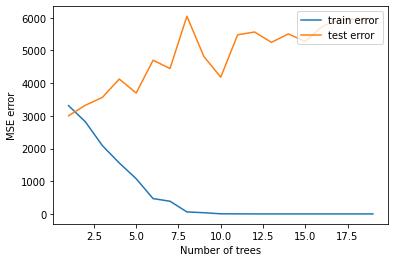

In [30]:
get_error_plot(max_depth_list, err_train_list, err_test_list)

### Вывод: при увеличении глубины деревьев, ошибка на трейне падает и достигает нуля при глубине 8. На тесте ошибка растет и достигает максимума при 8. Чрезмерная глубина деревьев приводит к переобучению.